# Tutorial for the Bayesian machine scientist 

This tutorial illustrates how to program a Bayesian machine scientist, using the code provided here. The tutorial assumes general knowledge of Python programming. We start by importing all necessary Python modules:

In [41]:
import sys
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

from ipywidgets import IntProgress
from IPython.display import display

sys.path.append('./')
sys.path.append('./Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

## Loading and preparing the data 

We then load the data. In this particular case, we load the salmon stocks data. The features (independent variables) are loaded into a Pandas `DataFrame` named `x`, whereas the target (dependent) variable is loaded into a Pandas `Series` named `y`. Data should **always** be loaded in these formats to avoid problems. 

In [3]:
XLABS = [
    'eff',
    'D_max',
    'D_apr',
    'D_may',
    'D_jun',
    'ET_apr',
    'ET_may',
    'ET_jun',
    'PT_apr',
    'PT_may',
    'PT_jun',
    'PT_jul',
    'PDO_win',
]
raw_data = pd.read_csv('Validation/LogYe/data/seymour.csv')
x, y = raw_data[XLABS], np.log(raw_data['rec'])
x.head()

,eff,D_max,D_apr,D_may,D_jun,ET_apr,ET_may,ET_jun,PT_apr,PT_may,PT_jun,PT_jul,PDO_win
0,0.004697,12500,952,4160,8880,7.8,10.6,14.5,6.7,7.3,8.6,9.7,-1.544
1,0.011504,8040,1650,6040,6020,9.1,12.4,14.5,7.2,8.2,8.9,9.8,-1.012
2,0.002780,8330,1700,5670,6790,8.4,11.4,13.5,7.1,8.0,8.6,9.3,-0.496
3,0.002907,7220,920,4960,6020,9.1,12.2,14.4,7.6,8.5,9.1,9.9,-0.682
4,0.012463,9060,796,4100,7600,8.4,12.3,13.2,7.5,8.3,8.8,9.2,-0.472


## Initializing the Bayesian machine scienstist 

We start by initializing the machine scientist. This involves three steps:
- **Reading the prior hyperparameters.** The values of the hyperparameters depend on the number of variables `nv` and parameters `np`considered during the search. Many combinations of `np` and `nv` have hyperparameters calculated in the `Prior` directory. Otherwise, the hyperparameters should be fit. 
- **Setting the "temperatures" for the parallel tempering.** If you don't know what parallel tempering is, you can read it in the Methods section of the paper, or just leave it as is in the code. In general, more temperatures (here 20) lead to better sampling of the expression space (we use a maximum of 100 different temperatures)
- **Initializing the (parallel) scientist.**

In [22]:
# Read the hyperparameters for the prior
prior_par = read_prior_par('./Prior/final_prior_param_sq.named_equations.nv13.np13.2016-09-01 17:05:57.196882.dat')

# Set the temperatures for the parallel tempering
Ts = [1] + [1.04**k for k in range(1, 20)]

# Initialize the parallel machine scientist
pms = Parallel(
    Ts,
    variables=XLABS,
    parameters=['a%d' % i for i in range(13)],
    x=x, y=y,
    prior_par=prior_par,
)

## Sampling expressions with the Bayesian machine scientist 

We are now ready to start sampling expressions with the Bayesian machine scientist, using MCMC. In its simplest form, one just needs to run the `mcmc_step()` and the `tree_swap()` methods as many times as necessary. `mcmc_step()` performs an MCMC update at each of the temperatures of the parallel tempering, whereas `tree_swap()` attempts to swap the expressions at two consecutive temperatures.

In [36]:
# Number of MCMC steps
nstep = 100

# Draw a progress bar to keep track of the MCMC progress
f = IntProgress(min=0, max=nstep, description='Running:') # instantiate the bar
display(f)

# MCMC
for i in range(nstep):
    # MCMC update
    pms.mcmc_step() # MCMC step within each T
    pms.tree_swap() # Attempt to swap two randomly selected consecutive temps
    # Update the progress bar
    f.value += 1

IntProgress(value=0, description=u'Running:')

Typically, of course, one wants to do something other than just generate expressions. For example, one may want to keep track of the most plausible (or, equivalently, the minimum description length) model visited so far by the MCMC, or keep a trace of some of the properties of the sampled expressions. 

In [49]:
# Number of MCMC steps
nstep = 10000

# Draw a progress bar to keep track of the MCMC progress
f = IntProgress(min=0, max=nstep, description='Running:') # instantiate the bar
display(f)

# MCMC
description_lengths, mdl, mdl_model = [], np.inf, None
for i in range(nstep):
    # MCMC update
    pms.mcmc_step() # MCMC step within each T
    pms.tree_swap() # Attempt to swap two randomly selected consecutive temps
    # Add the description length to the trace
    description_lengths.append(pms.t1.E)
    # Check if this is the MDL expression so far
    if pms.t1.E < mdl:
        mdl, mdl_model = pms.t1.E, deepcopy(pms.t1)
    # Update the progress bar
    f.value += 1

IntProgress(value=0, description=u'Running:', max=10000)

In [51]:
mdl, mdl_model

(93.4244313473869, (_a5_ * ((log(eff) * PT_may) ** 2)))

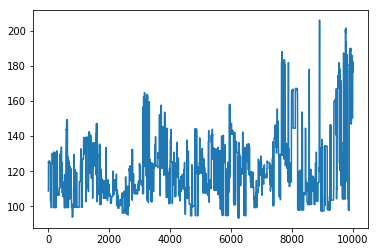

In [52]:
import matplotlib.pyplot as plt

plt.plot(description_lengths)